In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import numpy as np
from numpy import polyfit
from scipy import stats
import RegscorePy as rp
from numpy import sqrt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import itertools
import chow_test

from statistics import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('./data/RTS-history-USA.csv')
series = Model(np.array([i for i in df.Open[::25]]))

df2 = pd.read_csv('./data/RTS-history-USA.csv', parse_dates=True, index_col='Date')
df2 = df2[::25]

### Сам график и сглаживания

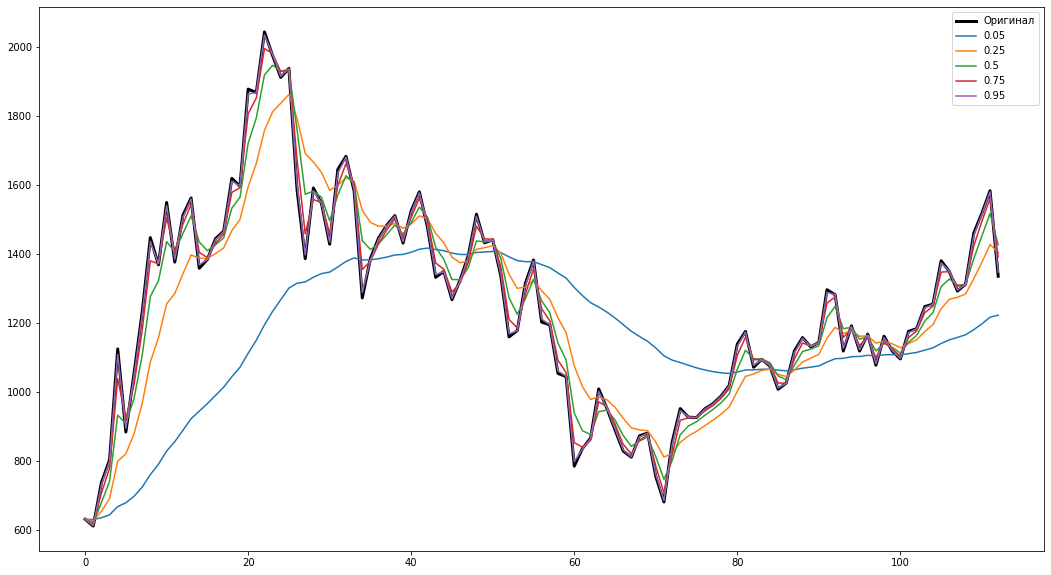

In [3]:
plt.figure(figsize=(18, 10))
draw(series, label='Оригинал', color='000', linewidth=3)
for a in [.05, .25, .5, .75, .95]:
    result = series.exponential_smoothing(a)
    plt.plot(result.seq, label=str(a))
plt.legend()
plt.show()

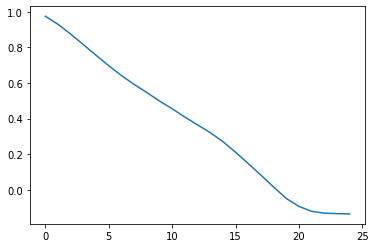

In [4]:
draw(series.exponential_smoothing(.5).many_acf(1, 25));

### Тест фуллера на стационарность ряда

In [5]:
series.fuller_test()

(-2.670316461994629,
 0.07931716496293206,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1212.2077258437034)

### Поиск и отображение тренда графика

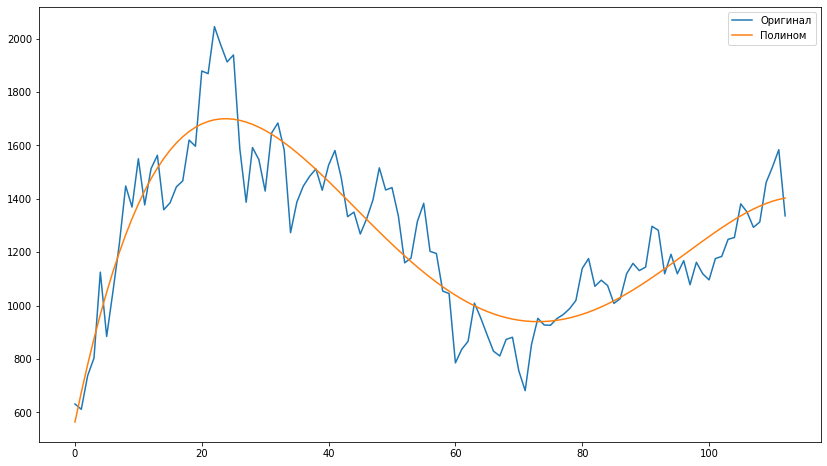

In [6]:
trend_line = series.trend(4)
plt.figure(figsize=(14, 8))
draw(series, label='Оригинал')
draw(trend_line, label='Полином')
plt.legend()
plt.show()

### Расчет КФ детерминации

In [7]:
series.determination_kf(4)

0.805586569565061

### Скорректированный КФ детерм

In [8]:
series.adjusted_determination_kf(4)

0.8002357412044664

### Значимость КФ автокорреляции 2-го порядка

In [9]:
kf2 = series.exponential_smoothing(.5).acf(2)
kf2 / (1-kf2**2/(len(series)-2))**.5

0.9338383925415732

### Декомпозиция

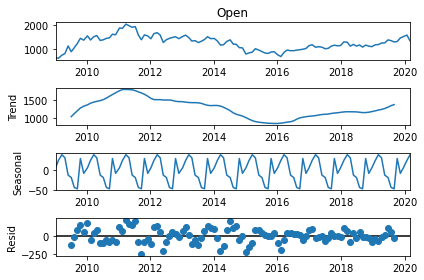

In [10]:
import statsmodels.api as sm

df2.Open.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(df2.Open, period=10)
res.plot();

### Нахождение остатков после вычитания тренда

In [11]:
remains = series - trend_line

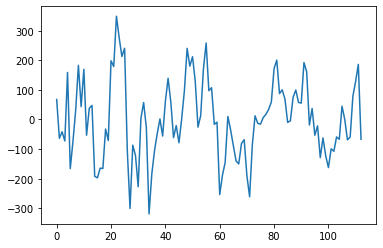

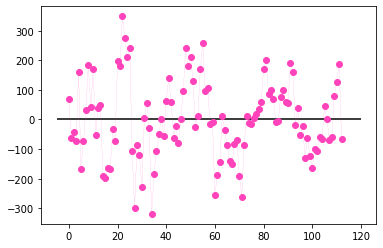

In [12]:
draw(remains);
plt.show()
fig, ax = plt.subplots()
draw(remains, marker='o', color='#f4b', linewidth=.1);
ax.hlines(0, -5, 120);

### Критерий Фишера для уравнения тренда 

In [13]:
series.fisher(4)

150.55361810849305

## Значимость КФ регрессии по Стьюденту

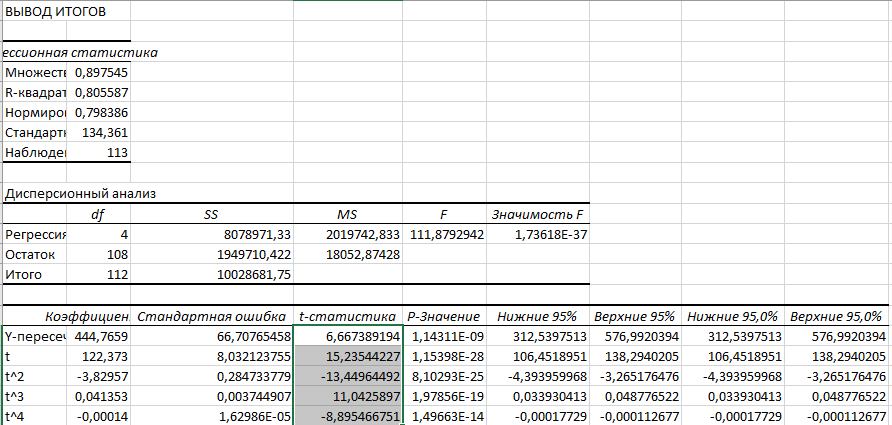

### Критерий Шварца

In [14]:
series.bic(trend_line)

9.964980051513505

### Критерий Акаике

In [15]:
series.aic(trend_line)

9.84429917457933

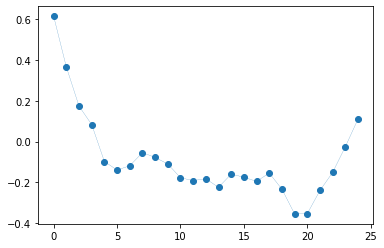

In [16]:
draw(remains.many_acf(1,25), marker='o', linewidth=.2);

### Критерий Жакка-Бера на нормальность распределения

In [17]:
stats.jarque_bera(remains)

(0.5095735668305718, 0.7750817406258271)

### РС критерий на нормальность распределения

In [18]:
(remains.max() - remains.min()) / ((remains**2).sum()/len(series)-1)**.5

5.085495701916399

### Тест Дарбина Уотсона на автокорреляцию

In [19]:
# Сравнить с таблицей!

In [20]:
remains.durbin_watson_test()

0.7705080573236872

### Тест на значимость КФ автокорреляции

In [21]:
kf = remains.acf(1)
sqrt((kf**2)/(1-kf**2)*(len(remains)-2))

8.193201354824389

### Тест на равенство средних

In [22]:
stats.ttest_ind(series[:60], series[60:])

Ttest_indResult(statistic=6.430267317147217, pvalue=3.3086141740613716e-09)

In [23]:
# Поскольку у нас p-value очень мало, то гипотеза h0 - о равенстве средних отвергается

In [24]:
p1 = remains[:55]
p2 = remains[55:]
abs(p1.mean() - p2.mean()) / sqrt(np.var(p1)/len(p1) + np.var(p2)/len(p2))

0.7148925714768324

### Тест на гетероскедастичность (Гольфельд Квандт)

### ARIMA

In [25]:
# 9 0 7

In [26]:
m, f = Arima.find_optimal_model_by_order(remains, 9, 0, 7)

ARIMA : 100%|██████████| 1/1 [00:41<00:00, 41.31s/ fit]


In [27]:
f.aic, f.order

(9.341447997384506, (9, 0, 7))

ARIMA : 100%|██████████| 1/1 [00:35<00:00, 35.49s/ fit]


((7, 0, 8), 9.33340074758108)

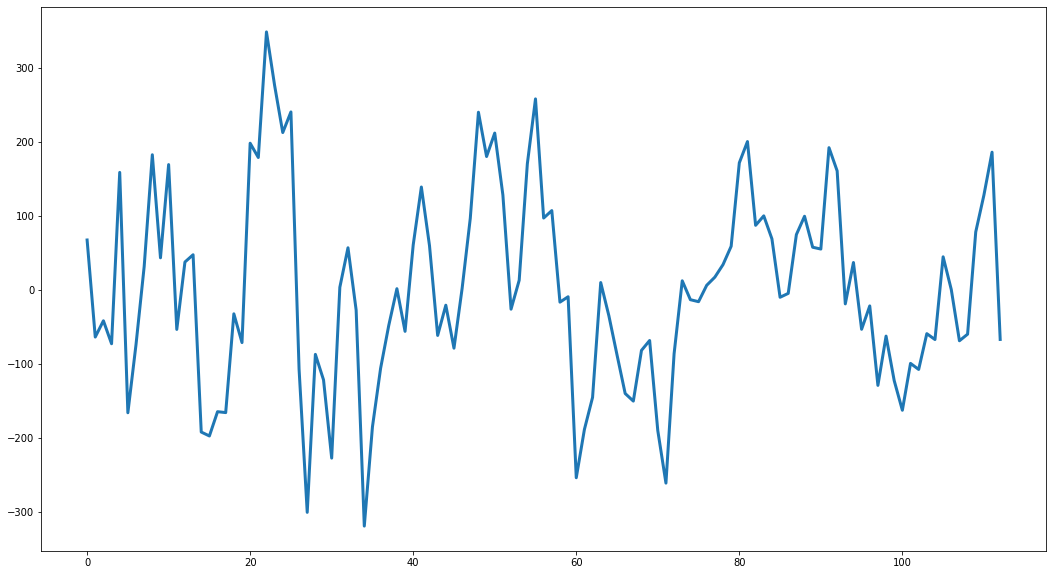

In [28]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(remains, label='Orig', linewidth=3)

# 7 0 8 - наилучшие
model, fitted_model = Arima.find_optimal_model_by_order(remains, 7, 0, 8)
fitted_model.order, fitted_model.aic

In [29]:
fitted_model.arparams

array([ 0.91147226,  0.2277196 , -0.4282041 ,  0.17270712,  0.04720058,
        0.51243451, -0.61617799])

In [30]:
trend_line

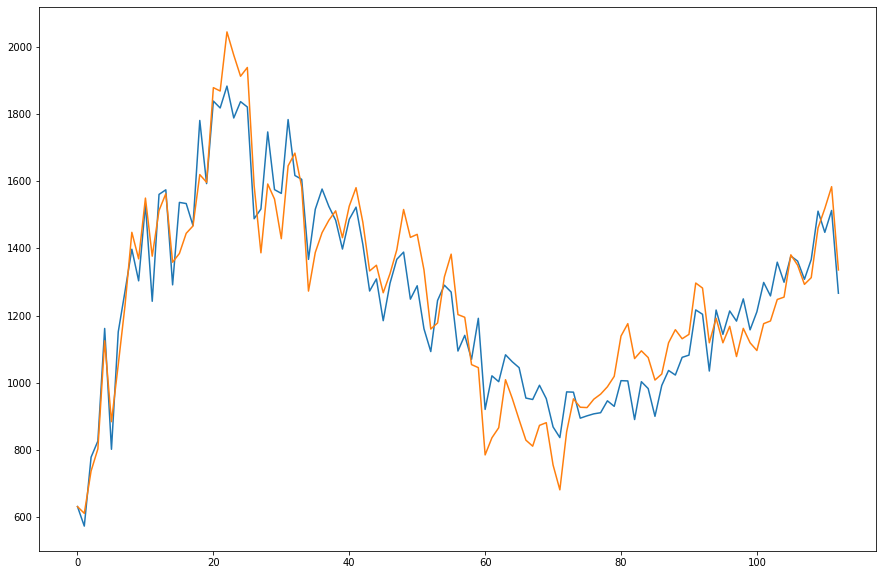

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(trend_line + fitted_model.resid)
ax.plot(series);

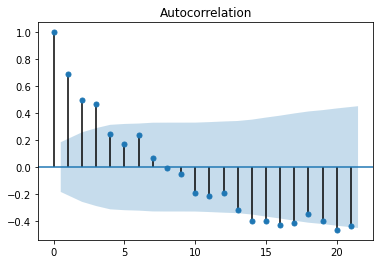

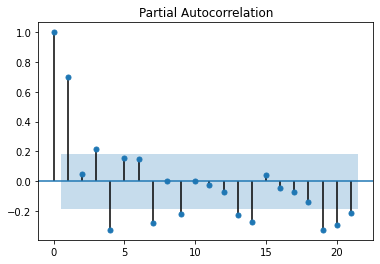

In [32]:
plot_acf(remains - fitted_model.resid)
plot_pacf(remains - fitted_model.resid);

###  Q-test Льюинга Бокса для проверки гипотезы о случайности остатков

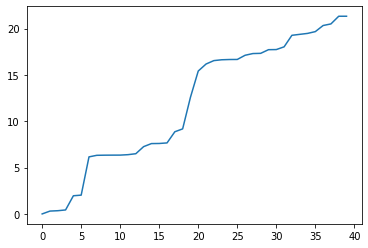

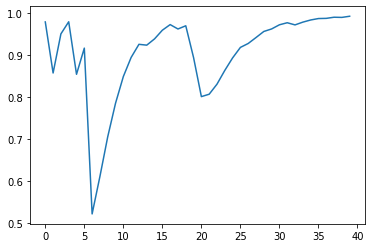

In [33]:
q_test = acf(fitted_model.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();

### Тест Дики Фуллера на стационарность остатков

In [34]:
test_df = adfuller(remains)
if test_df[0] > test_df[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
test_df

Ряд стационарен


(-5.130422100748794,
 1.217307664803825e-05,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1197.077681342571)

## Поскольку все значения p-value больше 0.05, это свидетельствует о том, что гипотеза об отсутствии автокорреляции не отвергается (на уровне значимости 5%) 

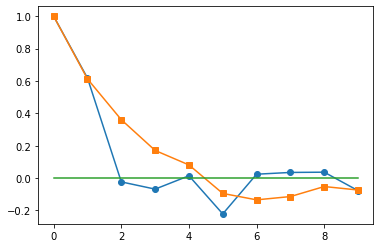

In [35]:
plt.plot(pacf(remains)[:10], marker='o', label='PACF')
plt.plot(acf(remains, fft=False)[:10], marker='s')
plt.plot([0]*10)
plt.show();

### Тесты на гомоскедантичность (p-value < 0.05 - гетероскедантичность?)

In [36]:
test_bartlett = stats.bartlett(remains, range(len(remains)))
test_levene = stats.levene(remains, range(len(remains)))
print(test_bartlett)
print(test_levene)

BartlettResult(statistic=169.41630151628857, pvalue=9.923235819367831e-39)
LeveneResult(statistic=96.43696551179367, pvalue=3.69259124387947e-19)


In [37]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:                     ARMA(7, 8)   Log Likelihood                -669.769
Method:                       css-mle   S.D. of innovations             83.560
Date:                Wed, 11 Mar 2020   AIC                           1373.538
Time:                        20:09:01   BIC                           1419.904
Sample:                             0   HQIC                          1392.353
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1611      0.743     -0.217      0.828      -1.617       1.295
ar.L1.y        0.9115      0.140      6.509      0.000       0.637       1.186
ar.L2.y        0.2277      0.188      1.213      0.225      -0.140       0.596
ar.L3.y       -0.4282      0.131     -3.264      0.001      -0.685      -0.171
ar.L4.y        0.1727      0.156      1.106      0.269      -0.133       0.479
ar.L5.y        0.0472      0.171      0.276      0.782      -0.288       0.382
ar.L6.y        0.5124      0.139      3.699      0.000       0.241       0.784
ar.L7.y       -0.6162      0.086     -7.177      0.000      -0.784      -0.448
ma.L1.y       -0.5102      0.164     -3.106      0.002      -0.832      -0.188
ma.L2.y       -0.5246      0.133     -3.952      0.000      -0.785      -0.264
ma.L3.y        0.0106      0.090      0.118      0.906      -0.166       0.187
ma.L4.y        0.1210      0.067      1.812      0.070      -0.010       0.252
ma.L5.y       -0.2904      0.076     -3.802      0.000      -0.440      -0.141
ma.L6.y       -0.8642      0.080    -10.861      0.000      -1.020      -0.708
ma.L7.y        0.7901      0.128      6.150      0.000       0.538       1.042
ma.L8.y        0.2679      0.144      1.857      0.063      -0.015       0.551
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0002           -0.0000j            1.0002           -0.5000
AR.2           -0.6391           -0.9709j            1.1623           -0.3426
AR.3           -0.6391           +0.9709j            1.1623            0.3426
AR.4            0.5372           -0.9118j            1.0582           -0.1653
AR.5            0.5372           +0.9118j            1.0582            0.1653
AR.6            1.0178           -0.1914j            1.0356           -0.0296
AR.7            1.0178           +0.1914j            1.0356            0.0296
MA.1            1.0005           -0.0010j            1.0005           -0.0002
MA.2            1.0005           +0.0010j            1.0005            0.0002
MA.3            0.4710           -0.8821j            1.0000           -0.1719
MA.4            0.4710           +0.8821j            1.0000            0.1719
MA.5           -0.5814           -0.8136j            1.0000           -0.3487
MA.6           -0.5814           +0.8136j            1.0000            0.3487
MA.7           -1.0000           -0.0000j            1.0000           -0.5000
MA.8           -3.7295           -0.0000j            3.7295           -0.5000
-----------------------------------------------------------------------------
"""

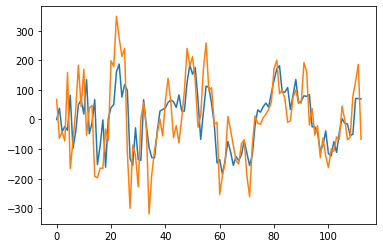

In [38]:
draw(remains - fitted_model.resid);
# plt.show()
draw(remains);

# ARIMA на исходные данные 

In [107]:
model2 = series.arima(order=(5, 1, 6))
fitted_model2 = model2.fit()

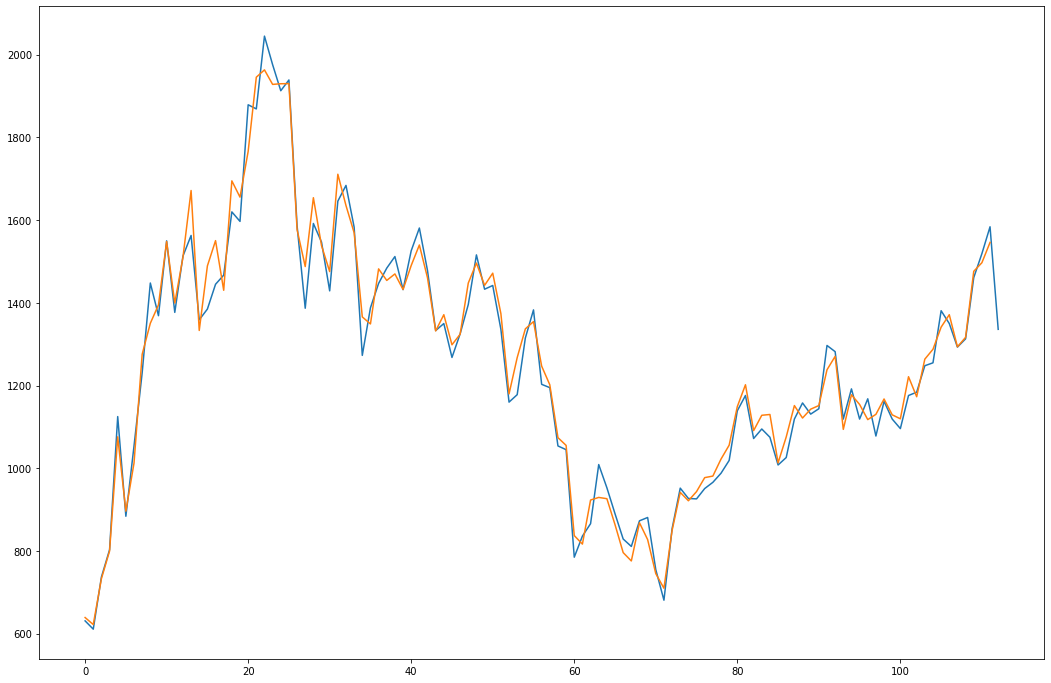

In [40]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(series);
ax.plot(series[1:] - fitted_model2.resid);
plt.show()

#### Остатки после тренда и остатки после аримы

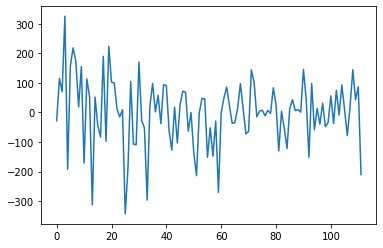

In [41]:
draw(fitted_model2.resid);

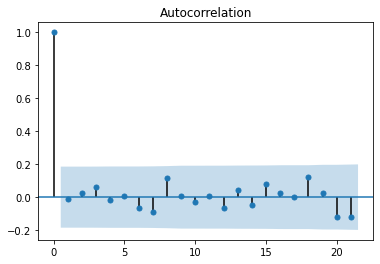

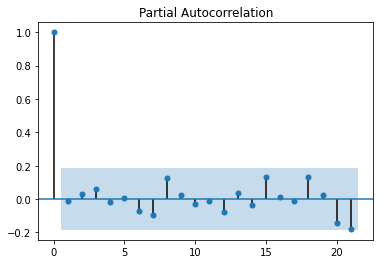

In [42]:
plot_acf(fitted_model2.resid);
plot_pacf(fitted_model2.resid);

In [43]:
# Вроде как 5 1 6 пушка акимбо 8 0 8 / 8 1 8
model3, fitted_model3 = Arima.find_optimal_model_by_order(series, 8, 0, 8)

ARIMA : 100%|██████████| 1/1 [01:23<00:00, 83.34s/ fit]


##### Результат вроде как белый шум

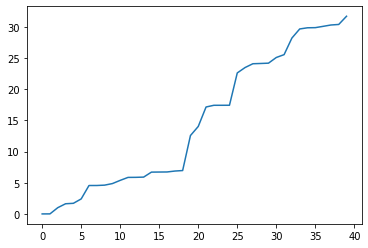

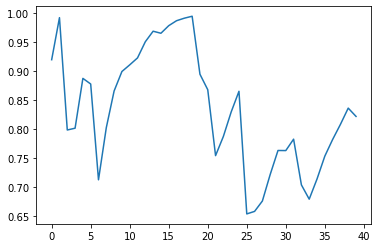

In [44]:
q_test = acf(fitted_model3.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();

# 3-я Глава

### Тест CHOW

CHOW : 100%|██████████| 12769/12769 [00:10<00:00, 1271.83 test/s]


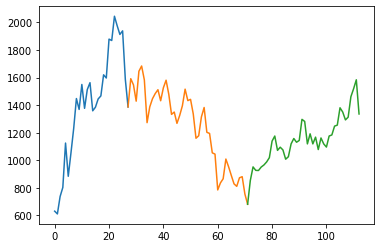

In [120]:
pm = series.cut_by_chow_test(arbitrarily=3)
draw(pm);
# draw(PartialModel(*pm.each_trend(3)).join().exponential_smoothing(.3));

### Результаты теста ЧОУ

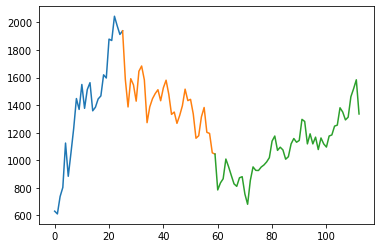

In [46]:
partial_series = PartialModel(series[:26], series[26:60], series[60:])
partial_trend = PartialModel(*partial_series.each_trend(3))
partial_remains = PartialModel(
    partial_series.p1-partial_trend.p1, partial_series.p2-partial_trend.p2, partial_series.p3-partial_trend.p3
)
draw(partial_series)

### Первый кусок

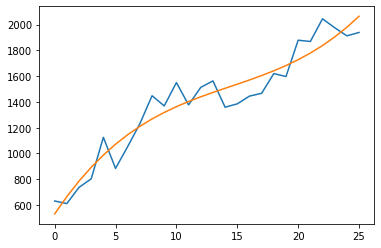

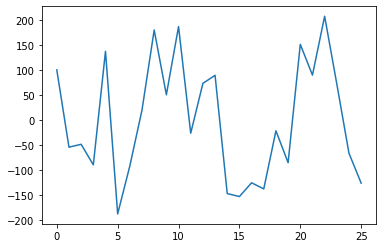

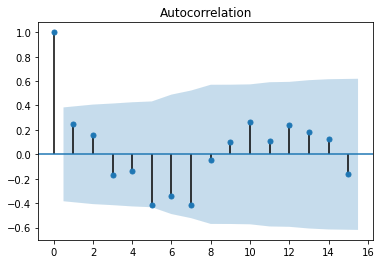

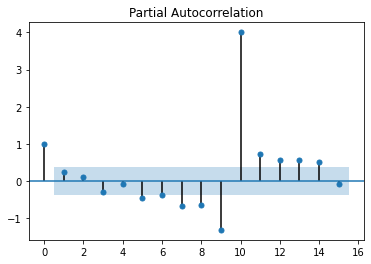

In [47]:
draw(partial_series.p1)
draw(partial_trend.p1);
plt.show()
draw(partial_remains.p1);
plot_acf(partial_remains.p1);
plot_pacf(partial_remains.p1);

### Второй кусок

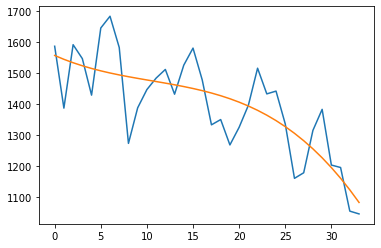

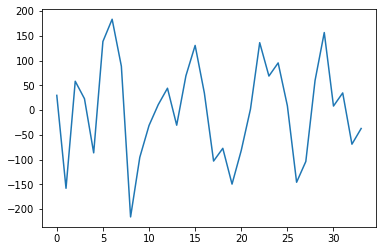

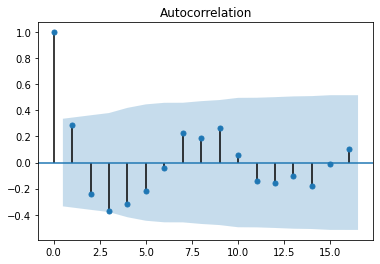

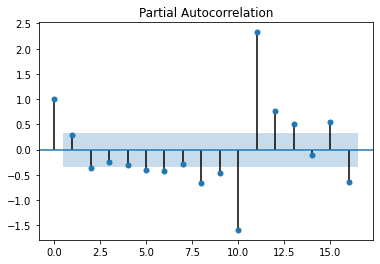

In [48]:
draw(partial_series.p2)
draw(partial_trend.p2);
plt.show()
draw(partial_remains.p2);
plot_acf(partial_remains.p2);
plot_pacf(partial_remains.p2);

### Третий кусок

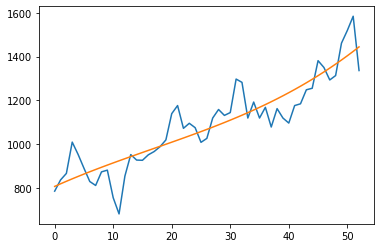

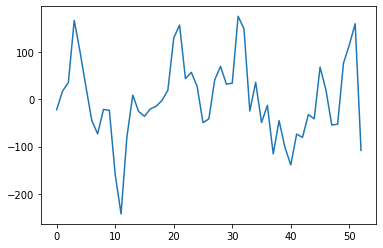

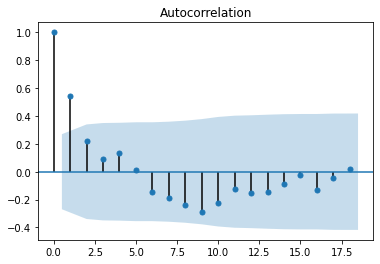

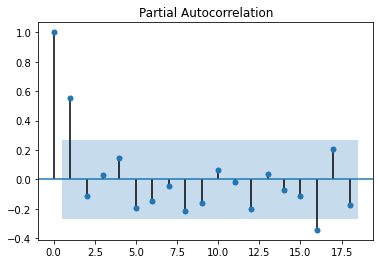

In [49]:
draw(partial_series.p3)
draw(partial_trend.p3);
plt.show()
draw(partial_remains.p3);
plot_acf(partial_remains.p3);
plot_pacf(partial_remains.p3);

### Общий кусочный тренд

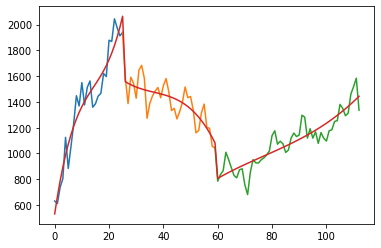

In [108]:
draw(partial_series)
draw(partial_trend.join());

### Остатки 

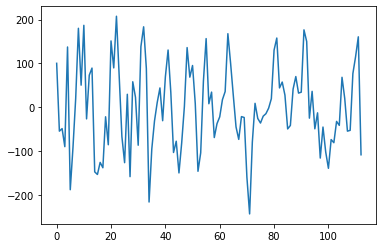

In [110]:
draw(partial_series.join() - partial_trend.join());

### КФ детерминации кусочного тренда

In [53]:
determination = partial_series.join().partial_determination_kf(partial_trend.join())

In [54]:
model1, fitted1 = Arima.find_optimal_model_by_order(partial_remains.p1, range(3), (0, 1), range(4))
model2, fitted2 = Arima.find_optimal_model_by_order(partial_remains.p2, range(3), (0, 1), range(4))
model3, fitted3 = Arima.find_optimal_model_by_order(partial_remains.p3, range(3), (0, 1), range(4))

print('P1', fitted1.order, fitted1.aic)
print('P2', fitted2.order, fitted2.aic)
print('P3', fitted3.order, fitted3.aic)

fitted_trend = PartialModel(
    partial_trend.p1 + fitted1.seq, partial_trend.p2 + fitted2.seq, partial_trend.p3 + fitted3.seq
)

ARIMA : 100%|██████████| 24/24 [00:02<00:00, 10.32 fit/s]

P1 (1, 0, 0) 9.53673115636221
P2 (2, 0, 1) 8.870756983657554
P3 (0, 0, 2) 8.559775237775487


### Тренд +АРИМА

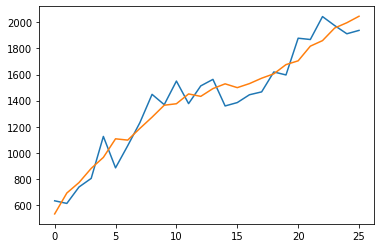

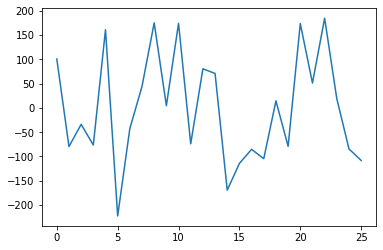

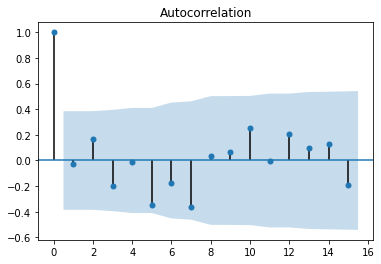

In [55]:
draw(partial_series.p1)
draw(fitted_trend.p1)
plt.show()
draw(partial_series.p1 - fitted_trend.p1)
plt.show()
plot_acf(partial_series.p1 - fitted_trend.p1);

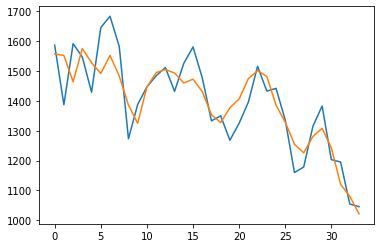

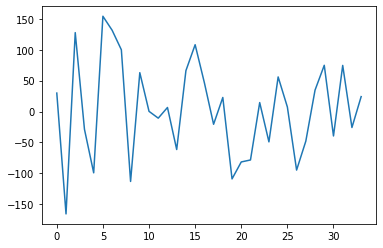

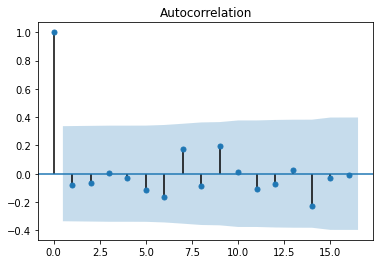

In [56]:
draw(partial_series.p2)
draw(fitted_trend.p2)
plt.show()
draw(partial_series.p2 - fitted_trend.p2)
plt.show()
plot_acf(partial_series.p2 - fitted_trend.p2);

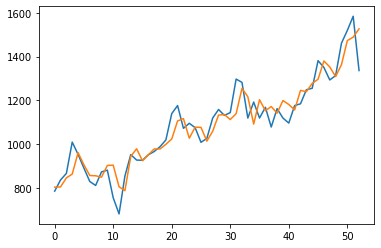

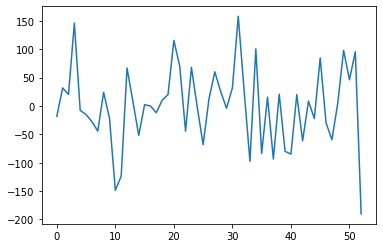

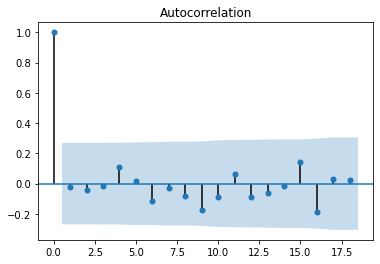

In [57]:
draw(partial_series.p3)
draw(fitted_trend.p3)
plt.show()
draw(partial_series.p3 - fitted_trend.p3)
plt.show()
plot_acf(partial_series.p3 - fitted_trend.p3);

### Склеил тренд + АРИМА (для каждого куска)

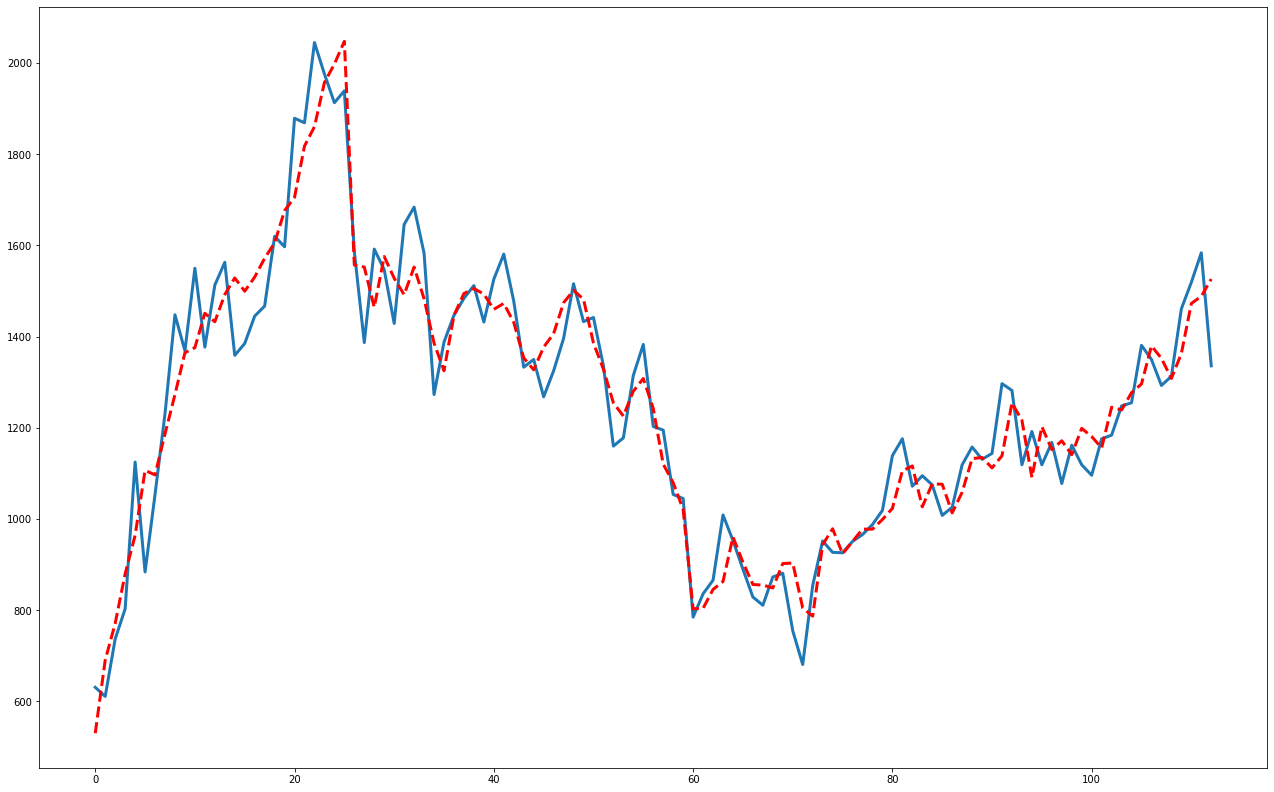

In [70]:
plt.figure(figsize=(22, 14))
draw(partial_series.join(), linewidth=3)
draw(fitted_trend.join(), 'r--', linewidth=3);

In [59]:
series.partial_determination_kf(fitted_trend.join())

0.9302611344696466

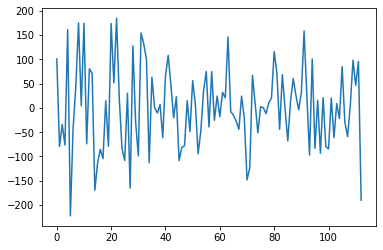

In [60]:
draw(series-fitted_trend.join());

### АРИМА на остатки всей модели

In [124]:
model_arima_remains, fitted_arima_remains = Arima.find_optimal_model_by_order(
    partial_series.join() - partial_trend.join(), range(3), range(2), range(3)
)
fitted_arima_remains.aic

ARIMA : 100%|██████████| 18/18 [00:02<00:00,  7.87 fit/s]


8.947437013897199

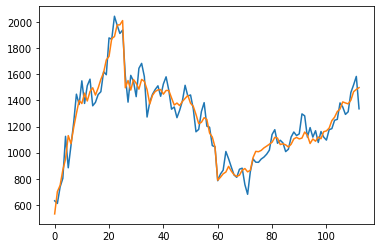

In [128]:
draw(series)
draw(partial_trend.join()+fitted_arima_remains.seq);